In [36]:
import scipy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Spin
from pprint import pprint
from dimod import ExactSolver

#myqlm imports
from qat.lang.AQASM import *
from qat.lang.AQASM import *
from qat.qpus import get_default_qpu
import import_ipynb
import ipynb

from QAOAutils import SolverQAOA

# Problema do Clique

O Problema do Clique consiste em encontrar um subgrafo completo, $\hat{G}$, composto por $K$ vértices (nós), em um dado grafo $G(V,E)$. Um grafo é completo quando todos os seus vértices nós interconectados.


Visualizando um $K\text{-Clique}$ com `Networkx`

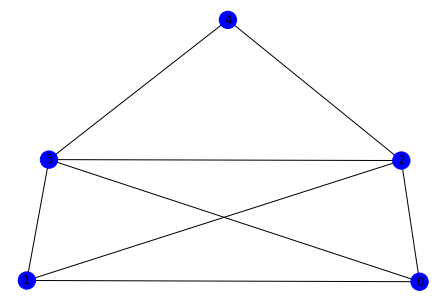

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()

#Criando um grafo G
G.add_edges_from([(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(3,4),(2,4)])
color_map = ['blue' for node in G]
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()


#### Visualização de um Clique de tamanho $K=4$

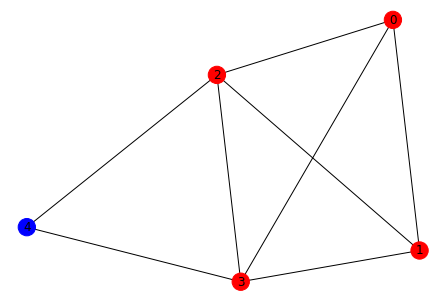

In [38]:
color_map = ['red' for _ in range(4)] + ['blue']
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

É possível verificar que o conjunto dos vértices $|V_c| = \{0,1,2,3\} $ formam um clique de tamanho $K=4$, pois formam um grafo completo. 

## Formulação como Otimização Irrestrita

Formularemos o problema como uma função de otimização com variáveis binárias, $x_i \in \{0,1\}$, sendo que o "estado" de cada vértice é dado por $x_i$. Se $x_i = 1$, indica que o vértice de índice $i$ faz parte do clique. A solução do exemplo com o grafo apresentado anteriormente é dada por $\vec{x} = 11110$, visto que apenas o vértice $4$ não faz parte do clique.

Apresentaremos dois termos de penalidades necessários para escrever o Problema do Clique como Otimização Irrestrita. Um dos termos está relacionado ao fato de que o número de vértices no estado $x_i = 1$ deve ser igual a $K$. Para isso, criamos o termo

$$ H_a = \left(K - \sum_{i=0}^{N}x_i\right)^2. $$

Quanto maior a diferença entre $K$ e o número de vértices em estado $1$, maior será a penalidade na função objetivo. O valor de $H_a$ será $0$ (mínimo) quando o critério for atendido. Contudo, claramente, essa condição não é suficiente para garantir que o clique seja encontrado. Para isso, introduziremos outros conceitos, começando pela quantidade de vértices em um clique. Essa quantidade é dada por

$$C = \frac{K(K-1)}{2}.$$

Logo, introduziremos um novo termo na função objetivo, cujo papel desempenhado é o de penalizar a função caso o número de arestas do subgrafo que conectam os nós de estado $x_i = 1$ seja diferente de $C$. Queremos que a quantidade de arestas do clique seja igual a $C$, logo, criamos o seguinte termo:

$$H_b = C - \sum_{<ij>}x_ix_j$$
onde $<ij>$ representa os índices apenas dos vértices conectados entre si. Introduziremos ainda as variáveis de penalidade dadas por $A$ e $B$, que são números inteiros usados para controlar a função objetivo e garantir que as restrições serão atendidas, pois podera as penalidades. Sendo assim, a função objetivo final é dada por 

$$H = A\left(K - \sum_{i=0}^{N}x_i\right)^2 + B\left( C - \sum_{<ij>}x_ix_j\right).$$

Neste problema, devemos considerar as constantes de penalidade satisfaznedo $A > B$.

### Exercício 1:

Substitua a resposta correta pelos FIXMEs no código abaixo.

In [39]:
# ------------------------------------------------- #
# Usando PyQubo para escrever a função objetivo
# ------------------------------------------------- #

# codificando o grafo do exemplo anterior
K=4
num_nodes = 5
C = K*(K-1)/2
A,B = 4,1

nodes = [node for node in range(num_nodes)]
G = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(3,4),(2,4)]

nodes_sum = 0 
for i in nodes:
    nodes_sum += Binary("x" + str(i))

HA = FIXME #(K - nodes_sum)**2

edges_sum = 0
for edge in G:
    edges_sum += Binary("x" + str(edge[0]))*Binary("x" + str(edge[1]))

HB = FIXME #(C - edges_sum)

H = FIXME #A*HA + B*HB

model = H.compile()

In [40]:
qaoa_myqlm = SolverQAOA(binary_model = model, num_variables = num_nodes, num_measurements = 200, depth=1)

In [41]:
phase_circuit = qaoa_myqlm.phase_op(gamma = np.pi)

%qatdisplay phase_circuit --svg

In [42]:
mix_circuit = qaoa_myqlm.mixer_op(beta = np.pi)
%qatdisplay mix_circuit --svg

In [43]:
# camada única do QAOA e medidas para chute inicial de gamma e beta
initial_guess = [np.pi/3, np.pi]
full_circ, initial_meas = qaoa_myqlm.full_circuit_measurements(initial_guess)
%qatdisplay full_circ --svg

<BarContainer object of 32 artists>

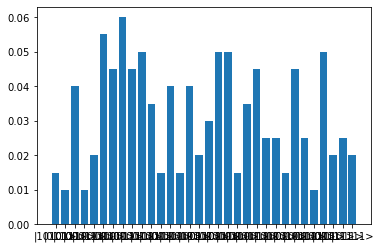

In [44]:
states=[]; probs = []
for key, value in initial_meas.items():
    states.append(str(key))
    probs.append(value)

plt.bar(states, probs)

In [45]:
# cada energia relacionada a um autoestado
# exemplo:
energy_11110 = qaoa_myqlm.cost_function('11110')
print("Energia associada ao autoestado |11110>:  ", energy_11110, "\n",70*"#")

# valor esperado de energia <psi|H|psi> para os chutes iniciais:
exp_val = qaoa_myqlm.expected_value(initial_guess)
print(" \n \n Valor esperado de energia para o chute inicial:  ", exp_val, "\n",70*"#")

Energia associada ao autoestado |11110>:   -70.0 
 ######################################################################
 
 
 Valor esperado de energia para o chute inicial:   -52.26 
 ######################################################################


In [46]:
res = qaoa_myqlm.run()


 
 QAOA solution:  |11110>
Pyqubo solution:  {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 0}
